In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.getcwd()

'/content'

In [3]:
os.chdir('/content/drive/MyDrive')
print(os.getcwd())

/content/drive/MyDrive


In [4]:
from IPython.display import clear_output
!pip install pyclustering

clear_output(wait=True)
print('All the packages were installed')

All the packages were installed


In [5]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
import itertools
import re

#Main classification metrics and utilities
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import silhouette_score, silhouette_samples

#Clustering Algorithms
from sklearn.cluster import OPTICS
from pyclustering.cluster import xmeans


def read_csv(path):
    return pd.read_csv(path, header=None, delimiter=r"\s+")

def reindex(df, new_idx):
    return df.loc[new_idx].reset_index(drop=True)

#loading the features' names (each line ends with the \n special char)
with open('UCI HAR Dataset/features.txt', 'r') as f:
    columns = [el.rstrip('\n') for el in f.readlines()] 
    
#opening the training files
labels_train = read_csv('UCI HAR Dataset/train/y_train.txt')
ind_train = read_csv('UCI HAR Dataset/train/subject_train.txt')
df_train = read_csv('UCI HAR Dataset/train/X_train.txt')
df_train.columns = columns

#opening the test files
labels_test = read_csv('UCI HAR Dataset/test/y_test.txt')
ind_test = read_csv('UCI HAR Dataset/test/subject_test.txt')
df_test = read_csv('UCI HAR Dataset/test/X_test.txt')
df_test.columns = columns

#shuffling the training set
train_indices_shuffle = shuffle(df_train.index, random_state=42)
    
labels_train = reindex(labels_train, train_indices_shuffle)
ind_train = reindex(ind_train, train_indices_shuffle)
df_train = reindex(df_train, train_indices_shuffle)

#shuffling the test set
test_indices_shuffle = shuffle(df_test.index, random_state=42)

labels_test = reindex(labels_test, test_indices_shuffle)
ind_test = reindex(ind_test, test_indices_shuffle)
df_test = reindex(df_test, test_indices_shuffle)

#concatenate training and test set for the EDA
df = pd.concat([df_train, df_test], ignore_index=True)
individuals = pd.concat([ind_train, ind_test], ignore_index=True)
labels = pd.concat([labels_train, labels_test], ignore_index=True)

#remapping the labels to their meaning to enhance readability (info were in )
with open('UCI HAR Dataset/activity_labels.txt', 'r') as f:
    act_lab = dict(el.strip().split(' ') for el in f.readlines())
to_remap = labels[0]
remap_dict = dict((int(k), v) for k, v in act_lab.items())
remapped_labels = [remap_dict.get(number, number) for number in to_remap]
print(remap_dict)

#inserting the the column of the feature labels as the first column
df.insert(loc=0, column='label', value=remapped_labels)
df.insert(loc=1, column='individuals', value=individuals.values)

{1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS', 4: 'SITTING', 5: 'STANDING', 6: 'LAYING'}


In [6]:
#useful variables
reverted_map_dict = {v: k for k, v in remap_dict.items()} #just reverting it to get numbers from the text labels
mapping_color = {'WALKING' : 'b', 'WALKING_UPSTAIRS' : 'r', 'WALKING_DOWNSTAIRS' : 'g', 'SITTING' : 'y', 'STANDING' : 'c', 'LAYING' : 'm'} #setting the color I will use from now on

#features to keep from the decision tree importances
features_to_keep = ['10 tBodyAcc-max()-X',
 '42 tGravityAcc-mean()-Y',
 '53 tGravityAcc-min()-X',
 '66 tGravityAcc-arCoeff()-X,1',
 '74 tGravityAcc-arCoeff()-Z,1',
 '167 tBodyGyroJerk-mad()-X',
 '297 fBodyAcc-skewness()-X',
 '331 fBodyAcc-bandsEnergy()-1,8',
 '411 fBodyAccJerk-bandsEnergy()-9,16',
 '427 fBodyGyro-std()-X',
 '504 fBodyAccMag-std()',
 '560 angle(Y,gravityMean)']

#REDUCED DATAFRAME from those features
rdf = df[['label', 'individuals']+features_to_keep]

#outliers to drop found in the anomaly detection task
to_drop = [2175, 2239, 2389, 3309]
rdf = rdf.drop(index=to_drop).reset_index()
rdf.columns = ['original_indexing']+rdf.columns.tolist()[1:]

#where to split the training and test set
split_val = len(ind_train)-len(to_drop)-1 #for pandas: 0 is the first position and the index indicated for the slicing is included
#pay attention that you have to add it back a 1 if you are splitting with a list or np.array as there the value indicated is not included if it's the last element of the slicing
print('Split train-test at row-index:', split_val)

#training set considered
rdf_train = rdf.loc[:split_val]
rdf_train_val = rdf_train[features_to_keep].values

#test set considered
rdf_test = rdf.loc[split_val+1:]
rdf_test_val = rdf_test[features_to_keep].values

rdf

Split train-test at row-index: 7347


,original_indexing,label,individuals,10 tBodyAcc-max()-X,42 tGravityAcc-mean()-Y,53 tGravityAcc-min()-X,"66 tGravityAcc-arCoeff()-X,1","74 tGravityAcc-arCoeff()-Z,1",167 tBodyGyroJerk-mad()-X,297 fBodyAcc-skewness()-X,"331 fBodyAcc-bandsEnergy()-1,8","411 fBodyAccJerk-bandsEnergy()-9,16",427 fBodyGyro-std()-X,504 fBodyAccMag-std(),"560 angle(Y,gravityMean)"
0,0,WALKING_DOWNSTAIRS,22,0.465563,-0.198698,0.910931,-0.727809,-0.366162,-0.318012,0.787213,-0.872989,-0.635353,-0.162709,-0.027400,0.222960
1,1,WALKING_DOWNSTAIRS,7,0.586004,-0.137829,0.886878,-0.430736,-0.461135,-0.479952,0.015080,-0.173580,-0.373514,-0.297979,0.220396,0.178975
2,2,WALKING,27,0.074430,-0.159944,0.983467,-0.444544,-0.027458,-0.586446,-0.146056,-0.871813,-0.734109,-0.699480,-0.541710,0.192929
3,3,SITTING,21,-0.931924,0.272900,0.879176,-0.354715,-0.836731,-0.988630,-0.343720,-0.999637,-0.999630,-0.990721,-0.992667,-0.106678
4,4,WALKING_DOWNSTAIRS,29,0.562230,-0.096393,0.940240,-0.661670,-0.614440,-0.342756,-0.062700,-0.793212,-0.875178,-0.018269,-0.053877,0.150598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10290,10294,WALKING_DOWNSTAIRS,13,-0.079271,-0.207134,0.943534,-0.415175,-0.344206,-0.592250,0.005763,-0.624565,-0.800755,-0.380399,-0.305962,0.224618
10291,10295,SITTING,10,-0.934545,-0.150343,0.988306,-0.592385,-0.663477,-0.987019,-0.508912,-0.996780,-0.999578,-0.968255,-0.967303,0.186200
10292,10296,LAYING,10,-0.924946,-0.998467,-0.366038,-0.464497,-0.164093,-0.988051,-0.072394,-0.999795,-0.999941,-0.991647,-0.989869,0.998808
10293,10297,WALKING,12,-0.128721,-0.144532,0.971368,-0.417347,-0.286710,-0.505736,-0.378576,-0.800462,-0.726337,-0.677292,-0.515498,0.182817


In [7]:
X = rdf_train_val
X

array([[ 0.46556308, -0.19869836,  0.91093055, ..., -0.16270862,
        -0.02740019,  0.22296008],
       [ 0.58600413, -0.13782888,  0.88687848, ..., -0.29797932,
         0.22039624,  0.17897518],
       [ 0.07443048, -0.15994439,  0.98346727, ..., -0.69947986,
        -0.54171042,  0.1929294 ],
       ...,
       [-0.54708209, -0.14622349,  0.98033458, ..., -0.45808676,
        -0.65760637,  0.18354749],
       [-0.93750321,  0.00373565,  0.97523317, ..., -0.99555935,
        -0.98664963,  0.08138803],
       [-0.21684098, -0.15236424,  0.97115335, ..., -0.30732214,
        -0.52518218,  0.18822594]])

# OPTICS

In [8]:
optics = OPTICS(min_samples=10, max_eps=np.inf, cluster_method='dbscan', eps=0.4)
optics.fit(X)

OPTICS(cluster_method='dbscan', eps=0.4, min_samples=10)

In [9]:
np.unique(optics.labels_, return_counts=True)

(array([-1,  0,  1,  2]), array([ 198, 3176, 3906,   68]))

In [10]:
len(np.unique(optics.labels_))

4

In [11]:
silhouette_score(X[optics.labels_ != -1], optics.labels_[optics.labels_ != -1])

0.37945569598812895

In [12]:
SSE = []
show = []
silh = []
silhouette_points = silhouette_samples(X, optics.labels_)

for i in range(3):
    cluster_singolo = pd.DataFrame(X[optics.labels_ == i])
    sommatoria_di_cluster = []
    for col in cluster_singolo.columns:
        mi = cluster_singolo[col].mean()
        differenza_elevata = []
        for x in cluster_singolo[col]:
            differenza_elevata.append((x - mi)**2)
        sommatoria = sum(differenza_elevata)
        sommatoria_di_cluster.append(sommatoria)
    SSE.append(sommatoria_di_cluster)
    show.append((i, len(cluster_singolo)))
    silh.append(np.mean(silhouette_points[np.array(optics.labels_) == i]))

SSE = np.asarray(SSE)
SSE_sum_x_features = sum(SSE)
SSE_sum_x_cluster = sum(SSE.T)
SSE_tot = sum(sum(SSE))

print('SSE x Cluster:\t', SSE_sum_x_cluster)
print('SSE TOT:\t', SSE_tot)

SSE x Cluster:	 [1498.15377421 3786.47201223   22.86987192]
SSE TOT:	 5307.495658360118


In [13]:
list(zip(np.array(show)[:,0], np.array(show)[:,1], SSE_sum_x_cluster, silh))

[(0, 3176, 1498.1537742087637, 0.4772037540984338),
 (1, 3906, 3786.472012231582, 0.2597096808563358),
 (2, 68, 22.86987191977092, 0.5648971890056858)]

In [14]:
pd.DataFrame(list(zip(np.array(show)[:,0], np.array(show)[:,1], SSE_sum_x_cluster, silh))).T

,0,1,2
0,0.000000,1.000000,2.000000
1,3176.000000,3906.000000,68.000000
2,1498.153774,3786.472012,22.869872
3,0.477204,0.259710,0.564897


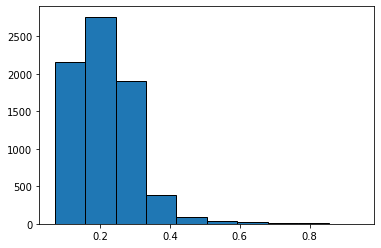

In [15]:
plt.hist(optics.reachability_[optics.ordering_][1:], edgecolor='k')
plt.title('')
plt.show()

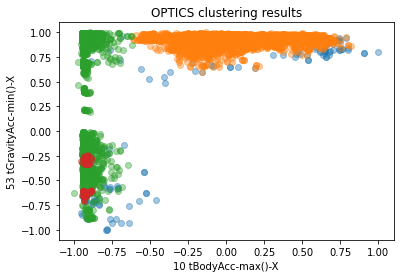

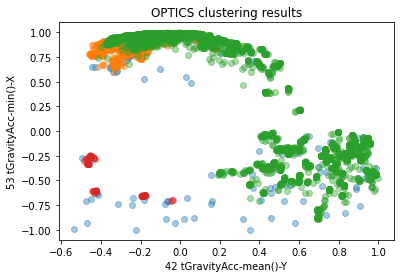

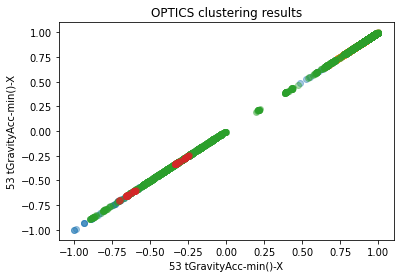

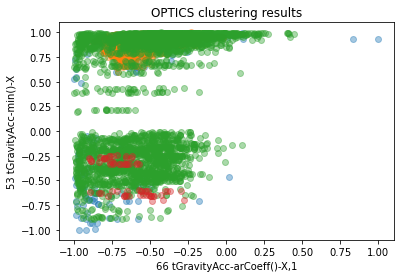

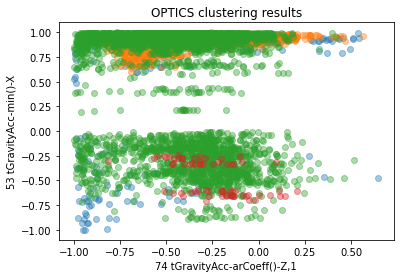

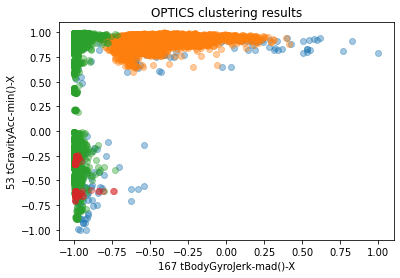

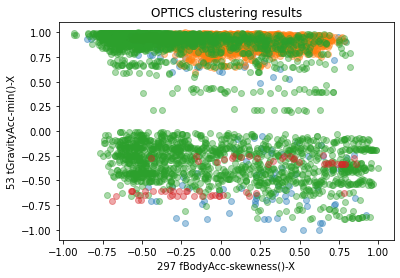

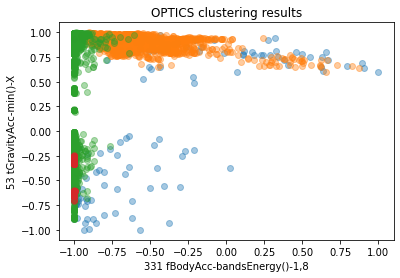

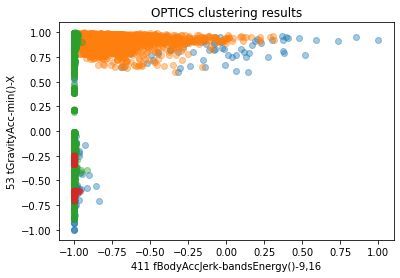

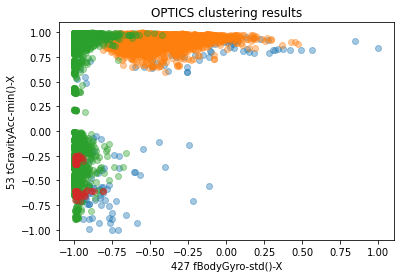

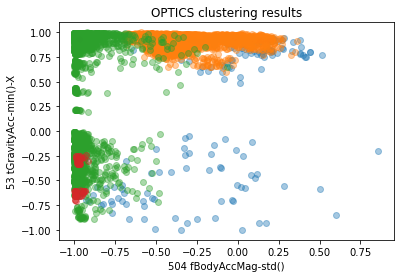

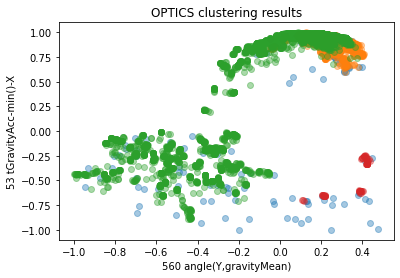

In [16]:
for x in features_to_keep:
    feat_x = x
    feat_y = '53 tGravityAcc-min()-X'
    i = features_to_keep.index(feat_x)
    j = features_to_keep.index(feat_y)

    for cluster_id in np.unique(optics.labels_)[:]:
        indexes = np.where(optics.labels_==cluster_id)
        plt.scatter(X[indexes,i], X[indexes,j], alpha=0.4)
    plt.xlabel(feat_x)
    plt.ylabel(feat_y)
    plt.title('OPTICS clustering results')
    plt.show()

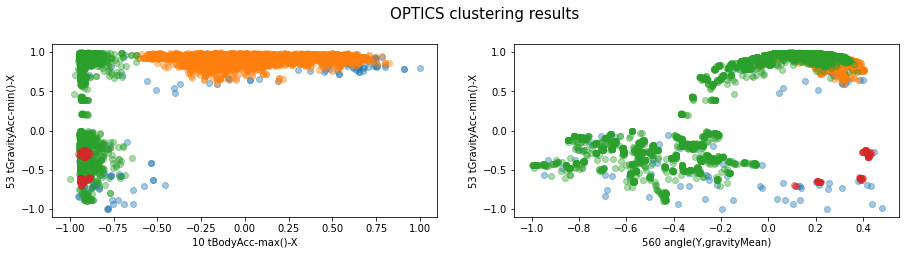

In [17]:
feat_x = features_to_keep[0]
feat_y = '53 tGravityAcc-min()-X'
i = features_to_keep.index(feat_x)
j = features_to_keep.index(feat_y)

fig = plt.subplots(figsize=(40, 26))
fig_dims = (7, 5)
plt.subplot2grid((fig_dims), (0, 0))
for cluster_id in np.unique(optics.labels_)[:]:
    indexes = np.where(optics.labels_==cluster_id)
    plt.scatter(X[indexes,i], X[indexes,j], alpha=0.4)
plt.xlabel(feat_x)
plt.ylabel(feat_y)

############################################

plt.subplot2grid((fig_dims), (0, 1))
feat_x = features_to_keep[-1]
feat_y = '53 tGravityAcc-min()-X'
i = features_to_keep.index(feat_x)
j = features_to_keep.index(feat_y)

for cluster_id in np.unique(optics.labels_)[:]:
    indexes = np.where(optics.labels_==cluster_id)
    plt.scatter(X[indexes,i], X[indexes,j], alpha=0.4)
plt.xlabel(feat_x)
plt.ylabel(feat_y)
plt.suptitle("OPTICS clustering results", x=0.275, y=0.9, fontsize=15)
plt.show()

In [18]:
np.unique(optics.labels_, return_counts=True)

(array([-1,  0,  1,  2]), array([ 198, 3176, 3906,   68]))

# XMEANS

In [19]:
xm = xmeans.xmeans(X)
xm.process()

print('SSE:', xm.get_total_wce())

SSE: 1414.9074329512819


In [20]:
clusters = xm.get_clusters()

In [21]:
len(clusters)

20

In [22]:
centers = xm.get_centers()

In [23]:
np.array(centers)

array([[-0.90717243, -0.15875147,  0.92442477, -0.67023966, -0.75199366,
        -0.97410539,  0.09032603, -0.97838777, -0.99889356, -0.94171102,
        -0.89624441,  0.19245634],
       [-0.90012218,  0.12789448,  0.83248393, -0.89072019, -0.89775871,
        -0.98141808,  0.43822982, -0.95051253, -0.9990452 , -0.96183524,
        -0.75329826, -0.00712263],
       [-0.9359206 ,  0.22093683,  0.87981709, -0.34163693, -0.25868061,
        -0.99186996, -0.53856991, -0.99949492, -0.99948597, -0.99266928,
        -0.98776856, -0.07197543],
       [-0.93172392,  0.32665381,  0.72442936, -0.56825787, -0.46608321,
        -0.99232082,  0.07599926, -0.99838026, -0.9995983 , -0.99113352,
        -0.97279455, -0.15083947],
       [-0.91187988, -0.18587741,  0.9492365 , -0.54558468, -0.7344091 ,
        -0.95527256, -0.46036366, -0.98416169, -0.99836105, -0.91357784,
        -0.91223396,  0.21085823],
       [-0.92786972, -0.02176274,  0.97328908, -0.37976655, -0.6121747 ,
        -0.9811562 , -

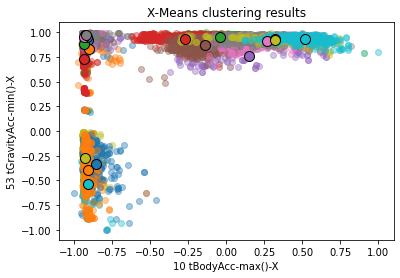

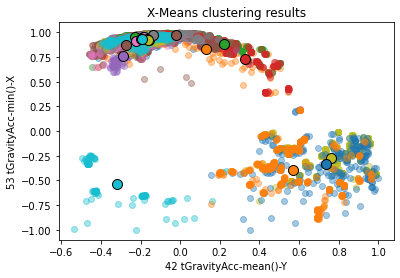

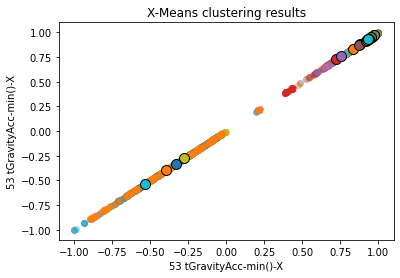

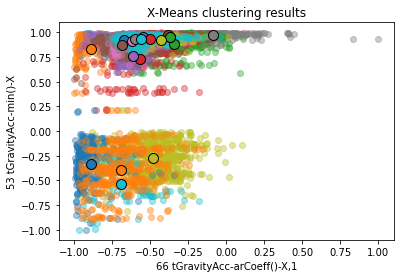

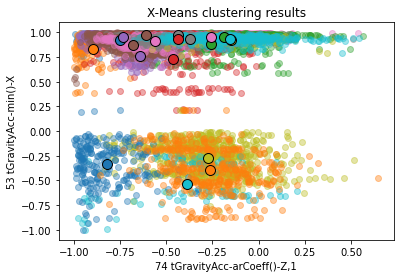

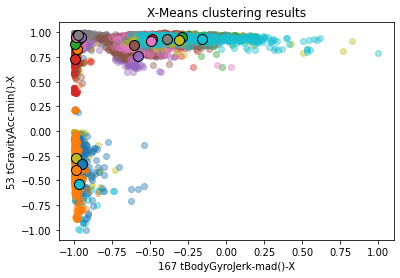

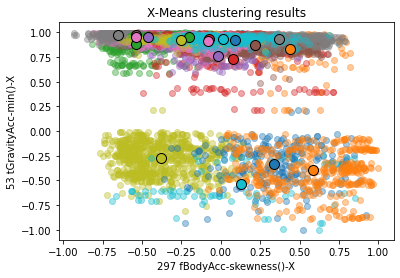

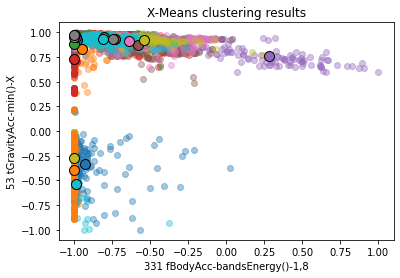

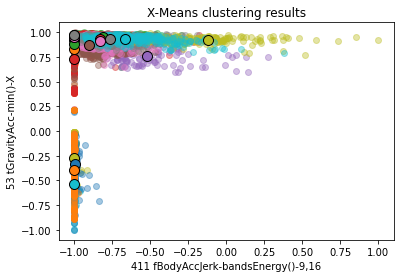

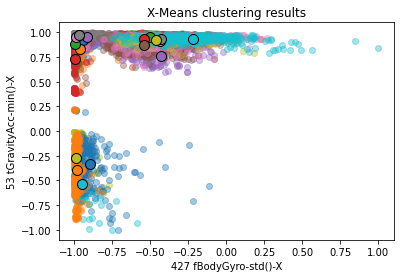

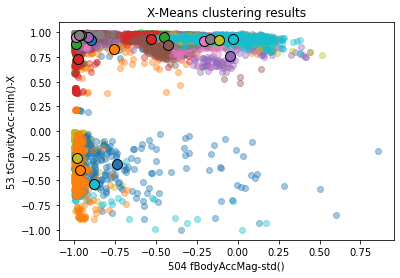

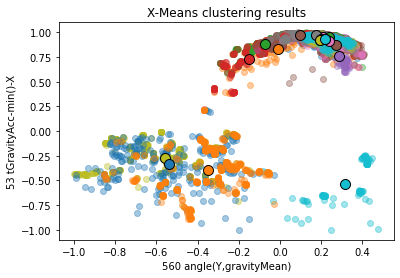

In [24]:
for x in features_to_keep:
    feat_x = x
    feat_y = '53 tGravityAcc-min()-X'
    i = features_to_keep.index(feat_x)
    j = features_to_keep.index(feat_y)

    for indexes in clusters:
        plt.scatter(X[indexes,i], X[indexes,j], alpha=0.4)
    for c in centers:
        plt.scatter(c[i], c[j], s=100, edgecolors='k')
    plt.xlabel(feat_x)
    plt.ylabel(feat_y)
    plt.title('X-Means clustering results')
    plt.show()

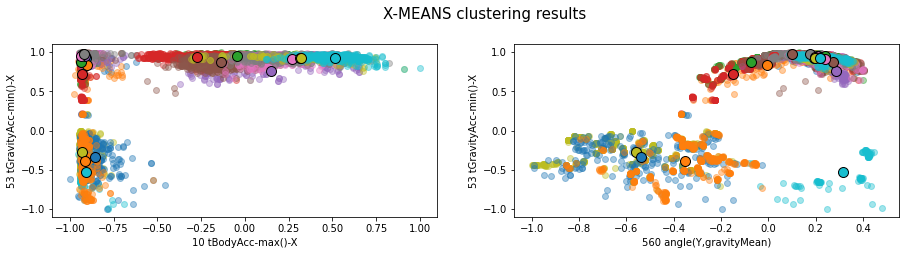

In [25]:
feat_x = features_to_keep[0]
feat_y = '53 tGravityAcc-min()-X'
i = features_to_keep.index(feat_x)
j = features_to_keep.index(feat_y)

fig = plt.subplots(figsize=(40, 26))
fig_dims = (7, 5)
plt.subplot2grid((fig_dims), (0, 0))
for indexes in clusters:
    plt.scatter(X[indexes,i], X[indexes,j], alpha=0.4)
for c in centers:
    plt.scatter(c[i], c[j], s=100, edgecolors='k')
plt.xlabel(feat_x)
plt.ylabel(feat_y)

#####################################à

plt.subplot2grid((fig_dims), (0, 1))
feat_x = features_to_keep[-1]
feat_y = '53 tGravityAcc-min()-X'
i = features_to_keep.index(feat_x)
j = features_to_keep.index(feat_y)

for indexes in clusters:
    plt.scatter(X[indexes,i], X[indexes,j], alpha=0.4)
for c in centers:
    plt.scatter(c[i], c[j], s=100, edgecolors='k')
plt.xlabel(feat_x)
plt.ylabel(feat_y)
plt.suptitle("X-MEANS clustering results", x=0.275, y=0.9, fontsize=15)
plt.show()

In [26]:
labeled_clusters = [list(zip(n*np.array([1 for _ in range(len(x))]), x)) for n, x in enumerate(clusters)]

joined_labeled = []
for x in labeled_clusters:
    joined_labeled += x
    
labeled_sorted = sorted(joined_labeled, key=lambda x: x[1])
clusters_labels_fix = [x[0] for x in labeled_sorted]

In [27]:
silhouette_score(X, clusters_labels_fix)

0.2101963992916933

In [28]:
xm.get_total_wce()

1414.9074329512819

In [29]:
np.unique(clusters_labels_fix)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [30]:
SSE = []
show = []
silh = []
silhouette_points = silhouette_samples(X, clusters_labels_fix)

for i in range(20):
    cluster_singolo = pd.DataFrame(X[np.array(clusters_labels_fix) == i])
    sommatoria_di_cluster = []
    for col in cluster_singolo.columns:
        mi = cluster_singolo[col].mean()
        differenza_elevata = []
        for x in cluster_singolo[col]:
            differenza_elevata.append((x - mi)**2)
        sommatoria = sum(differenza_elevata)
        sommatoria_di_cluster.append(sommatoria)
    SSE.append(sommatoria_di_cluster)
    show.append((i, len(cluster_singolo)))
    silh.append(np.mean(silhouette_points[np.array(clusters_labels_fix) == i]))

SSE = np.asarray(SSE)
SSE_sum_x_features = sum(SSE)
SSE_sum_x_cluster = sum(SSE.T)
SSE_tot = sum(sum(SSE))

print('SSE x Cluster:\t', SSE_sum_x_cluster)
print('SSE TOT:\t', SSE_tot)

SSE x Cluster:	 [ 24.4908024   28.42000693  37.08179156  38.92032104  39.5139372
  34.1559866   42.43994474  31.43932035 139.97999822  44.34403979
  87.59222907  97.48489127 110.57571883  86.517811    39.12052723
 125.83440451 104.07590754 108.90977303  61.6107491  132.39927255]
SSE TOT:	 1414.9074329512844


In [31]:
list(zip(np.array(show)[:,0], np.array(show)[:,1], SSE_sum_x_cluster, silh))

[(0, 148, 24.490802398949327, 0.1626537665083325),
 (1, 142, 28.420006926291293, 0.22028883245826572),
 (2, 362, 37.08179155852833, 0.21016631914434378),
 (3, 184, 38.92032103734934, 0.16536823459251043),
 (4, 384, 39.51393719529398, 0.11555651614710534),
 (5, 494, 34.155986603457876, 0.2019269259429876),
 (6, 576, 42.43994473526537, 0.2303980071916759),
 (7, 353, 31.439320346721967, 0.1710645536629476),
 (8, 691, 139.97999821874777, 0.4554832149030873),
 (9, 93, 44.34403978972769, 0.35094644648781353),
 (10, 235, 87.59222907423744, 0.2002905220298444),
 (11, 398, 97.4848912714246, 0.3122248275654912),
 (12, 590, 110.57571883339986, 0.17319373908043503),
 (13, 489, 86.51781100119446, 0.1676925134099939),
 (14, 102, 39.120527231316736, 0.2639977879285896),
 (15, 636, 125.83440451048666, 0.19463360608095692),
 (16, 476, 104.0759075430325, 0.14420385616310374),
 (17, 445, 108.90977303259304, 0.13329138017917916),
 (18, 145, 61.61074909710107, 0.12918649384200678),
 (19, 405, 132.399272546

In [32]:
pd.DataFrame(list(zip(np.array(show)[:,0], np.array(show)[:,1], SSE_sum_x_cluster, silh))).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000,15.000000,16.000000,17.000000,18.000000,19.000000
1,148.000000,142.000000,362.000000,184.000000,384.000000,494.000000,576.000000,353.000000,691.000000,93.000000,235.000000,398.000000,590.000000,489.000000,102.000000,636.000000,476.000000,445.000000,145.000000,405.000000
2,24.490802,28.420007,37.081792,38.920321,39.513937,34.155987,42.439945,31.439320,139.979998,44.344040,87.592229,97.484891,110.575719,86.517811,39.120527,125.834405,104.075908,108.909773,61.610749,132.399273
3,0.162654,0.220289,0.210166,0.165368,0.115557,0.201927,0.230398,0.171065,0.455483,0.350946,0.200291,0.312225,0.173194,0.167693,0.263998,0.194634,0.144204,0.133291,0.129186,0.111461


In [33]:
pd.DataFrame(pd.DataFrame(silh)[0].astype(float).round(4)).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.1627,0.2203,0.2102,0.1654,0.1156,0.2019,0.2304,0.1711,0.4555,0.3509,0.2003,0.3122,0.1732,0.1677,0.264,0.1946,0.1442,0.1333,0.1292,0.1115
